# Self-Supervised Audio Spectrogram Transformers

The functions read data info from a json, which can be set up with the following code


In [1]:
# set up data json
# input = folder with wav files, csv with labes that go with file names
# if csv with annotations is empty it will make up one

# prepare mayo speech data for ssl pretraining
import os,torchaudio,pickle,json,time

def walk(path, name, label_csv=None):
    sample_cnt = 0
    pathdata = os.walk(path)
    wav_list = []
    begin_time = time.time()
    for root, dirs, files in pathdata:
        for file in files:
            if file.endswith('.wav'):
                sample_cnt += 1

                cur_path = root + os.sep + file
                # give a dummy label of 'speech' ('/m/09x0r' in AudioSet label ontology) to all librispeech samples
                # the label is not used in the pretraining, it is just to make the dataloader.py satisfy.
                if label_csv==None:
                    label='/m/09x0r'
                
                #read label
                    
                
                cur_dict = {"wav": cur_path, "labels": label, "filename": file}
                wav_list.append(cur_dict)

                if sample_cnt % 1000 == 0:
                    end_time = time.time()
                    print('find {:d}k .wav files, time eclipse: {:.1f} seconds.'.format(int(sample_cnt/1000), end_time-begin_time))
                    begin_time = end_time
                if sample_cnt % 1e4 == 0:
                    with open(name + '.json', 'w') as f:
                        json.dump({'data': wav_list}, f, indent=1)
                    print('file saved.')
    print(sample_cnt)
    with open(name + '.json', 'w') as f:
        json.dump({'data': wav_list}, f, indent=1)


In [2]:
mayo_path = '/home/jupyter/mayo_legacy/mayo_legacy_all'
walk(mayo_path, 'mayo_legacy_all') # this saves in the current directory obv

0


Our fake argparser

In [3]:
# create fake args list
import argparse
import ast

parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--data-train", type=str, default=None, help="training data json")
parser.add_argument("--data-val", type=str, default=None, help="validation data json")
parser.add_argument("--data-eval", type=str, default=None, help="evaluation data json")
parser.add_argument("--label-csv", type=str, default='', help="csv with class labels")
parser.add_argument("--n_class", type=int, default=1, help="number of classes")

parser.add_argument("--dataset", type=str, help="the dataset used for training")
parser.add_argument("--dataset_mean", type=float, help="the dataset mean, used for input normalization")
parser.add_argument("--dataset_std", type=float, help="the dataset std, used for input normalization")
parser.add_argument("--target_length", type=int, help="the input length in frames")
parser.add_argument("--num_mel_bins", type=int, default=128, help="number of input mel bins")

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default=0.001, type=float, metavar='LR', help='initial learning rate')
parser.add_argument('--warmup', help='if use warmup learning rate scheduler', type=ast.literal_eval, default='True')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=24, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=16, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# only used in pretraining stage or from-scratch fine-tuning experiments
parser.add_argument("--lr_patience", type=int, default=1, help="how many epoch to wait to reduce lr if mAP doesn't improve")
parser.add_argument('--adaptschedule', help='if use adaptive scheduler ', type=ast.literal_eval, default='False')

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")
parser.add_argument('--save_model', help='save the models or not', type=ast.literal_eval)

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default=None, help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
# during self-supervised pretraining stage, no patch split overlapping is used (to aviod shortcuts), i.e., fstride=fshape and tstride=tshape
# during fine-tuning, using patch split overlapping (i.e., smaller {f,t}stride than {f,t}shape) improves the performance.
# it is OK to use different {f,t} stride in pretraining and finetuning stages (though fstride is better to keep the same)
# but {f,t}stride in pretraining and finetuning stages must be consistent.
parser.add_argument("--fstride", type=int, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument("--fshape", type=int, help="shape of patch on the frequency dimension")
parser.add_argument("--tshape", type=int, help="shape of patch on the time dimension")
parser.add_argument('--model_size', help='the size of AST models', type=str, default='base384')

parser.add_argument("--task", type=str, default='ft_cls', help="pretraining or fine-tuning task", choices=["ft_avgtok", "ft_cls", "pretrain_mpc", "pretrain_mpg", "pretrain_joint"])

# pretraining augments
parser.add_argument('--pretrain_stage', help='True for self-supervised pretraining stage, False for fine-tuning stage', type=ast.literal_eval, default='False')
parser.add_argument('--mask_patch', help='how many patches to mask (used only for ssl pretraining)', type=int, default=400)
parser.add_argument("--cluster_factor", type=int, default=3, help="mask clutering factor")
parser.add_argument("--epoch_iter", type=int, default=2000, help="for pretraining, how many iterations to verify and save models")

# fine-tuning arguments
parser.add_argument("--pretrained_mdl_path", type=str, default=None, help="the ssl pretrained models path")
parser.add_argument("--head_lr", type=int, default=1, help="the factor of mlp-head_lr/lr, used in some fine-tuning experiments only")
parser.add_argument("--noise", help='if augment noise in finetuning', type=ast.literal_eval)
parser.add_argument("--metrics", type=str, default="mAP", help="the main evaluation metrics in finetuning", choices=["mAP", "acc"])
parser.add_argument("--lrscheduler_start", default=10, type=int, help="when to start decay in finetuning")
parser.add_argument("--lrscheduler_step", default=5, type=int, help="the number of step to decrease the learning rate in finetuning")
parser.add_argument("--lrscheduler_decay", default=0.5, type=float, help="the learning rate decay ratio in finetuning")
parser.add_argument("--wa", help='if do weight averaging in finetuning', type=ast.literal_eval)
parser.add_argument("--wa_start", type=int, default=16, help="which epoch to start weight averaging in finetuning")
parser.add_argument("--wa_end", type=int, default=30, help="which epoch to end weight averaging in finetuning")
parser.add_argument("--loss", type=str, default="BCE", help="the loss function for finetuning, depend on the task", choices=["BCE", "CE"])


_StoreAction(option_strings=['--loss'], dest='loss', nargs=None, const=None, default='BCE', type=<class 'str'>, choices=['BCE', 'CE'], help='the loss function for finetuning, depend on the task', metavar=None)

This is the data loader

In [4]:
import csv
import json
import torchaudio
import numpy as np
import torch
import torch.nn.functional
from torch.utils.data import Dataset
import random

def make_index_dict(label_csv):
    index_lookup = {}
    with open(label_csv, 'r') as f:
        csv_reader = csv.DictReader(f)
        line_count = 0
        for row in csv_reader:
            index_lookup[row['mid']] = row['index']
            line_count += 1
    return index_lookup

def make_name_dict(label_csv):
    name_lookup = {}
    with open(label_csv, 'r') as f:
        csv_reader = csv.DictReader(f)
        line_count = 0
        for row in csv_reader:
            name_lookup[row['index']] = row['display_name']
            line_count += 1
    return name_lookup

def lookup_list(index_list, label_csv):
    label_list = []
    table = make_name_dict(label_csv)
    for item in index_list:
        label_list.append(table[item])
    return label_list

def preemphasis(signal,coeff=0.97):
    """perform preemphasis on the input signal.
    :param signal: The signal to filter.
    :param coeff: The preemphasis coefficient. 0 is none, default 0.97.
    :returns: the filtered signal.
    """
    return np.append(signal[0],signal[1:]-coeff*signal[:-1])

class AudioDataset(Dataset):
    def __init__(self, dataset_json_file, audio_conf, label_csv=None):
        """
        Dataset that manages audio recordings
        :param audio_conf: Dictionary containing the audio loading and preprocessing settings
        :param dataset_json_file
        """
        self.datapath = dataset_json_file
        with open(dataset_json_file, 'r') as fp:
            data_json = json.load(fp)

        self.data = data_json['data']
        self.audio_conf = audio_conf
        print('---------------the {:s} dataloader---------------'.format(self.audio_conf.get('mode')))
        self.melbins = self.audio_conf.get('num_mel_bins')
        self.freqm = self.audio_conf.get('freqm')
        self.timem = self.audio_conf.get('timem')
        print('now using following mask: {:d} freq, {:d} time'.format(self.audio_conf.get('freqm'), self.audio_conf.get('timem')))
        self.mixup = self.audio_conf.get('mixup')
        print('now using mix-up with rate {:f}'.format(self.mixup))
        self.dataset = self.audio_conf.get('dataset')
        print('now process ' + self.dataset)
        # dataset spectrogram mean and std, used to normalize the input
        self.norm_mean = self.audio_conf.get('mean')
        self.norm_std = self.audio_conf.get('std')
        # skip_norm is a flag that if you want to skip normalization to compute the normalization stats using src/get_norm_stats.py, if Ture, input normalization will be skipped for correctly calculating the stats.
        # set it as True ONLY when you are getting the normalization stats.
        self.skip_norm = self.audio_conf.get('skip_norm') if self.audio_conf.get('skip_norm') else False
        if self.skip_norm:
            print('now skip normalization (use it ONLY when you are computing the normalization stats).')
        else:
            print('use dataset mean {:.3f} and std {:.3f} to normalize the input.'.format(self.norm_mean, self.norm_std))
        # if add noise for data augmentation
        self.noise = self.audio_conf.get('noise')
        if self.noise == True:
            print('now use noise augmentation')

        self.index_dict = make_index_dict(label_csv)
        self.label_num = len(self.index_dict)
        print('number of classes is {:d}'.format(self.label_num))

    def _wav2fbank(self, filename, filename2=None):
        # mixup
        if filename2 == None:
            waveform, sr = torchaudio.load(filename)
            #waveform=waveform[0] ### added
            waveform = waveform - waveform.mean()
        # mixup
        else:
            waveform1, sr = torchaudio.load(filename)
            waveform2, _ = torchaudio.load(filename2)
            
            #waveform1=waveform1[0] ### added

            waveform1 = waveform1 - waveform1.mean()
            waveform2 = waveform2 - waveform2.mean()

            if waveform1.shape[1] != waveform2.shape[1]:
                if waveform1.shape[1] > waveform2.shape[1]:
                    # padding
                    temp_wav = torch.zeros(1, waveform1.shape[1])
                    temp_wav[0, 0:waveform2.shape[1]] = waveform2
                    waveform2 = temp_wav
                else:
                    # cutting
                    waveform2 = waveform2[0, 0:waveform1.shape[1]]

            # sample lambda from uniform distribution
            #mix_lambda = random.random()
            # sample lambda from beta distribtion
            mix_lambda = np.random.beta(10, 10)

            mix_waveform = mix_lambda * waveform1 + (1 - mix_lambda) * waveform2
            waveform = mix_waveform - mix_waveform.mean()

        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=self.melbins, dither=0.0, frame_shift=10)

        target_length = self.audio_conf.get('target_length')
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]

        if filename2 == None:
            return fbank, 0
        else:
            return fbank, mix_lambda

    def __getitem__(self, index):
        """
        returns: image, audio, nframes
        where image is a FloatTensor of size (3, H, W)
        audio is a FloatTensor of size (N_freq, N_frames) for spectrogram, or (N_frames) for waveform
        nframes is an integer
        """
        # do mix-up for this sample (controlled by the given mixup rate)
        if random.random() < self.mixup:
            datum = self.data[index]
            # find another sample to mix, also do balance sampling
            # sample the other sample from the multinomial distribution, will make the performance worse
            # mix_sample_idx = np.random.choice(len(self.data), p=self.sample_weight_file)
            # sample the other sample from the uniform distribution
            mix_sample_idx = random.randint(0, len(self.data)-1)
            mix_datum = self.data[mix_sample_idx]
            # get the mixed fbank
            fbank, mix_lambda = self._wav2fbank(datum['wav'], mix_datum['wav'])
            # initialize the label
            label_indices = np.zeros(self.label_num)
            # add sample 1 labels
            for label_str in datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] += mix_lambda
            # add sample 2 labels
            for label_str in mix_datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] += (1.0-mix_lambda)
            label_indices = torch.FloatTensor(label_indices)
            filename_item = datum['filename']
        # if not do mixup
        else:
            datum = self.data[index]
            label_indices = np.zeros(self.label_num)
            fbank, mix_lambda = self._wav2fbank(datum['wav'])
            for label_str in datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] = 1.0

            label_indices = torch.FloatTensor(label_indices)
            filename_item = datum['filename']

        # SpecAug, not do for eval set
        freqm = torchaudio.transforms.FrequencyMasking(self.freqm)
        timem = torchaudio.transforms.TimeMasking(self.timem)
        fbank = torch.transpose(fbank, 0, 1)
        # this is just to satisfy new torchaudio version.
        fbank = fbank.unsqueeze(0)
        if self.freqm != 0:
            fbank = freqm(fbank)
        if self.timem != 0:
            fbank = timem(fbank)
        # squeeze back
        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)

        # normalize the input for both training and test
        if not self.skip_norm:
            fbank = (fbank - self.norm_mean) / (self.norm_std * 2)
        # skip normalization the input if you are trying to get the normalization stats.
        else:
            pass

        if self.noise == True:
            fbank = fbank + torch.rand(fbank.shape[0], fbank.shape[1]) * np.random.rand() / 10
            fbank = torch.roll(fbank, np.random.randint(-10, 10), 0)

        # the output fbank shape is [time_frame_num, frequency_bins], e.g., [1024, 128]
        return fbank, label_indices, filename_item

    def __len__(self):
        return len(self.data)

Test it

In [5]:
label_csv='/home/jupyter/ast/ssast/src/prep_data/dummy_labels.csv'
print(make_index_dict(label_csv))
print(make_name_dict(label_csv))

{'/m/09x0r': '0'}
{'0': '"speech"'}


In [6]:
dataset_mean=-4.2677393
dataset_std=4.5689974
audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0, 'dataset': 'test',
              'mode':'train', 'mean':dataset_mean, 'std':dataset_std, 'noise':False}

In [7]:
label_csv='/home/jupyter/ast/ssast/src/prep_data/dummy_labels.csv'
tr_data='/home/jupyter/ast/mayo_legacy_smr_train.json'

test_loader=torch.utils.data.DataLoader(
    AudioDataset(tr_data, label_csv=label_csv, audio_conf=audio_conf),
    batch_size=10, shuffle=True, num_workers=10, pin_memory=False, drop_last=True)

---------------the train dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process test
use dataset mean -4.268 and std 4.569 to normalize the input.
number of classes is 1


In [8]:
test_loader.dataset[1]

(tensor([[ 0.3828,  0.4536,  0.5046,  ..., -0.3448, -0.2702, -0.2734],
         [ 0.2985,  0.3763,  0.4458,  ..., -0.3198, -0.3489, -0.2974],
         [ 0.3206,  0.4325,  0.5260,  ..., -0.3332, -0.3433, -0.3262],
         ...,
         [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670],
         [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670],
         [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670]]),
 tensor([1.]),
 'vfukts9.wav')

They have one main object, ASTModel, that can do pretraining and fine tuning for *many* different tasks etc. But that doesn't play nice with torchvision's feature extractor. So I have factored it into individual versions.

In [9]:
# modified from this file

# -*- coding: utf-8 -*-
# @Time    : 7/16/21 3:12 AM
# @Author  : Yuan Gong
# @Affiliation  : Massachusetts Institute of Technology
# @Email   : yuangong@mit.edu
# @File    : ast_models.py
# the unified ast models for all pretraining/fine-tuning tasks.


import torch.nn as nn
import torch
import sys
#sys.path.append("/data/sls/scratch/yuangong/aed-trans/src/models/")
#sys.path.append("/data/sls/scratch/yuangong/aed-trans/src/")
from timm.models.layers import trunc_normal_
import timm
import numpy as np
from timm.models.layers import to_2tuple
from random import randrange
from matplotlib import pyplot as plt
import random


# he defines his own patchembed object because the vision transformer from timm has restrictions on the dimensionality of the input which we want to bypass

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x
    
# He defines a sinusoidal positional encoding object


def get_sinusoid_encoding(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

# The options he has for ASTModel include
# model size - we will defauly this to 'base'

class ASTModel_pretrain(nn.Module):
    def __init__(self, label_dim=527,
                 fshape=128, tshape=2, fstride=128, tstride=2,
                 input_fdim=128, input_tdim=1024,
                 load_pretrained_mdl_path=None, imagenet=False, B=12):

        super(ASTModel_pretrain, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # pretrain the AST models
        self.pretrainedstage=True
        if load_pretrained_mdl_path != None:
            raise ValueError('Setting load_pretrained_mdl_path at pretraining stage is useless, pretraining is always from scratch, please change it to None.')
        if fstride != fshape or tstride != tshape:
            raise ValueError('fstride != fshape or tstride != tshape, they must be same at the pretraining stage, patch split overlapping is not supported.')

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        model_size = 'base'
        self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet)
        self.heads, self.depth = 12, 12
        self.cls_token_num = 2
        self.B=B    
        self.original_num_patches = self.v.patch_embed.num_patches
        self.oringal_hw = int(self.original_num_patches ** 0.5)
        self.original_embedding_dim = self.v.pos_embed.shape[2]

        # SSL Pretraining Code
        self.softmax = nn.Softmax(dim=-1)
        self.lsoftmax = nn.LogSoftmax(dim=-1)
        self.fshape, self.tshape = fshape, tshape
        self.fstride, self.tstride = fstride, tstride
        self.input_fdim, self.input_tdim = input_fdim, input_tdim
        # this is a trick to make state_dict to track pretraining input_fdim and input_tdim and save them by using torch.save
        self.p_input_fdim, self.p_input_tdim = nn.Parameter(torch.tensor(input_fdim), requires_grad=False), nn.Parameter(torch.tensor(input_tdim), requires_grad=False)

        # masked patch classification (discriminative objective) layer
        # we use two layers for pretext task, but using a single layer has similar performance.
        # we map the output of transformer (768-dim for base models) to 256-dim patch input space, and then dot product with flattened patch input (also 256-dim) to calculate loss.
        # alternatively, you can map the output of transformer to 768-dim patch embedding space, and dot product with patch embedding. Performance-wise they are similar, but map to 256 space is more efficient.
        self.cpredlayer = nn.Sequential(nn.Linear(self.original_embedding_dim, self.original_embedding_dim), nn.ReLU(), nn.Linear(self.original_embedding_dim, 256))
        # masked patch reconstruction (generative objective) layer
        self.gpredlayer = nn.Sequential(nn.Linear(self.original_embedding_dim, self.original_embedding_dim), nn.ReLU(), nn.Linear(self.original_embedding_dim, 256))
        self.unfold = torch.nn.Unfold(kernel_size=(fshape, tshape), stride=(fstride, tstride))

        # we use learnable mask embedding (follow the BEIT paper), but using a fixed mask embedding (e.g., 0) leads to same performance.
        self.mask_embed = nn.Parameter(torch.zeros([1, 1, self.original_embedding_dim]))
        self.mask_embed = torch.nn.init.xavier_normal_(self.mask_embed)

        # get the intermediate shape
        self.p_f_dim, self.p_t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim, fshape, tshape)
        num_patches = self.p_f_dim * self.p_t_dim
        self.num_patches = num_patches
        self.v.patch_embed.num_patches = num_patches
        print('pretraining patch split stride: frequency={:d}, time={:d}'.format(fstride, tstride))
        print('pretraining patch shape: frequency={:d}, time={:d}'.format(fshape, tshape))
        print('pretraining patch array dimension: frequency={:d}, time={:d}'.format(self.p_f_dim, self.p_t_dim))
        print('pretraining number of patches={:d}'.format(num_patches))
            
            
        # the linear patch projection layer, use 1 channel for spectrogram rather than the original 3 channels for RGB images.
        new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(fshape, tshape), stride=(fstride, tstride))
        self.v.patch_embed.proj = new_proj

        # use trainable positional embedding
        new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + self.cls_token_num, self.original_embedding_dim))
        self.v.pos_embed = new_pos_embed
        trunc_normal_(self.v.pos_embed, std=.02)
            
            
    # get the shape of intermediate representation.
    def get_shape(self, fstride, tstride, input_fdim, input_tdim, fshape, tshape):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(fshape, tshape), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    # generate mask for 16*16 patch
    def gen_maskid_patch(self, sequence_len=512, mask_size=100, cluster=3):
        mask_id = []

        # randomize clutering factor in [3,6)
        cur_clus = randrange(cluster) + 3

        while len(list(set(mask_id))) <= mask_size:
            start_id = randrange(sequence_len)

            # this improves the efficiency, but might change the pretrained model
            # while start_id in mask_id:
            #     start_id = randrange(sequence_len)

            cur_mask = []
            for i in range(0, cur_clus):
                for j in range(0, cur_clus):
                    mask_cand = start_id + self.p_t_dim * i + j
                    if mask_cand > 0 and mask_cand < sequence_len:
                        cur_mask.append(mask_cand)
            mask_id = mask_id + cur_mask
        mask_id = list(set(mask_id))[:mask_size]
        return torch.tensor(mask_id)

    # using cluster for frame masking hurts the performance, so just use the naive random sampling
    def gen_maskid_frame(self, sequence_len=512, mask_size=100):
        mask_id = random.sample(range(0, sequence_len), mask_size)
        return torch.tensor(mask_id)

  






    
    def finetuningavgtok(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # average output of all tokens except cls token(s)
        x = torch.mean(x[:, self.cls_token_num:, :], dim=1)
        x = self.mlp_head(x)
        return x
    
    def finetuningavgtok_embed(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # average output of all tokens except cls token(s)
        x = torch.mean(x[:, self.cls_token_num:, :], dim=1)
        #x = self.mlp_head(x)
        return x

    def finetuningcls(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # if models has two cls tokens (DEIT), average as the clip-level representation
        if self.cls_token_num == 2:
            x = (x[:, 0] + x[:, 1]) / 2
        else:
            x = x[:, 0]
        x = self.mlp_head(x)
        return x

    # masked patch pretraining with discriminative objective
    def mpc(self, x, mask_patch, cluster, B):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #input = self.unfold(x).transpose(1, 2)
        input = self.unfold(x)
        input = input.transpose(1, 2)
        #B = x.shape[0]
        B=self.B
        # x in shape (batch_size, sequence_len, embedding dim)
        x = self.v.patch_embed(x)
        #mask_patch=mask_patch

        # encode the patch
        # size 12(batch_size) * 100(#mask_patch) * 768(hidden_dim), prepare to save the true values of masked samples
        #encode_samples = torch.ones((B, mask_patch, 256), device=device, requires_grad=False, dtype=torch.float)
        encode_samples=x.new_zeros((B, mask_patch, 256), device=device, requires_grad=False).float
        # size 12(batch_size) * 100(#mask_patch), index of masked patches
        #mask_index = torch.empty((B, mask_patch), device=x.device, requires_grad=False).long()
        mask_index=x.new_zeros((B, mask_patch), device=device, requires_grad=False).long()
        # size 12(batch_size) * 512(sequence_len) * 768(hidden_dim)
        #mask_dense = torch.ones([x.shape[0], x.shape[1], x.shape[2]], device=x.device)
        mask_dense=x.new_zeros([x.shape[0], x.shape[1], x.shape[2]], device=device)

        # for each audio clip in the batch
        for i in range(B):
            # randomly generate #mask_patch mask indexes without duplicate
            #if cluster == True:
            #    # use this if you are masking e.g. 16*16 patches
            #    mask_index[i] = self.gen_maskid_patch(self.num_patches, mask_patch)
            #else:
                # use this if you are masking frame, i.e., 128*2 patches
            mask_index[i] = self.gen_maskid_frame(self.num_patches, mask_patch)
            # copy the masked embeddings, note gradients are stopped in this path
            encode_samples[i] = input[i, mask_index[i], :].clone().detach()
            # mask the encode samples with 0
            mask_dense[i, mask_index[i], :] = 0

        # follow BEIT paper, mask with learnable masking embedding, but no performance diff observed compared with masking with 0s.
        mask_tokens = self.mask_embed.expand(B, x.shape[1], -1)

        # mask the patch
        x = x * mask_dense + (1-mask_dense) * mask_tokens

        # pass through the Transformer layers
        cls_tokens = self.v.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)

        # prediction of the masked patch
        pred = torch.empty((B, mask_patch, 256), device=x.device).float()  # e.g. size 12*100*768
        for i in range(B):
            #  +2 for indexes because skipping the cls and dis token
            # we map the output of transformer (768-dim for base models) to 256-dim patch input space, and then dot product with flattened patch input (also 256-dim) to calculate loss.
            # alternatively, you can map the output of transformer to 768-dim patch embedding space, and dot product with patch embedding. Performance-wise they are similar, but map to 256 space is more efficient.
            pred[i] = self.cpredlayer(x[i, mask_index[i] + self.cls_token_num, :])

        # calculate the NCE loss
        nce = torch.tensor(0.0).to(x.device)
        correct = torch.tensor(0.0).to(x.device)
        for i in np.arange(0, B):
            # negative samples are from the same batch
            # equation (1) of the ssast paper
            total = torch.mm(encode_samples[i], torch.transpose(pred[i], 0, 1))  # e.g. size 100*100
            correct += torch.sum(torch.eq(torch.argmax(self.softmax(total), dim=0), torch.arange(0, mask_patch, device=x.device)))  # correct is a tensor
            nce += torch.sum(torch.diag(self.lsoftmax(total)))  # nce is a tensor
        acc = 1. * correct / (B * mask_patch)
        nce = nce / (-1. * B * mask_patch)

        
        return acc, nce
        

    # # masked patch pretraining with generative objective
    def mpg(self, input, mask_patch, cluster):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #B = input.shape[0]
        B=self.B
        x = self.v.patch_embed(input)
        input = self.unfold(input).transpose(1, 2)

        # size 12(batch_size) * 100(#mask_patch), index of masked patches
        mask_index = torch.empty((B, mask_patch), device=x.device, requires_grad=False).long()
        # size 12(batch_size) * 512(sequence_len) * 768(hidden_dim)
        mask_dense = torch.ones([x.shape[0], x.shape[1], x.shape[2]], device=x.device)
        for i in range(B):
            # randomly generate #mask_patch mask indexes without duplicate
            #if cluster == True:
                # use this if you are masking e.g. 16*16 patches
            #    mask_index[i] = self.gen_maskid_patch(self.num_patches, mask_patch)
            #else:
                # use this if you are masking frame, i.e., 128*2 patches
            mask_index[i] = self.gen_maskid_frame(self.num_patches, mask_patch)
            mask_dense[i, mask_index[i], :] = 0

        mask_tokens = self.mask_embed.expand(B, x.shape[1], -1)

        # follow BEIT paper, mask with learnable masking embedding, but no performance diff observed compared with masking with 0s.
        x = x * mask_dense + (1-mask_dense) * mask_tokens

        # go through the Transformer layers
        cls_tokens = self.v.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)

        pred = torch.empty((B, mask_patch, self.fshape * self.tshape), device=x.device).float()  # e.g. size 12*100*256
        target = torch.empty((B, mask_patch, self.fshape * self.tshape), device=x.device).float() # e.g. size 12*100*256

        for i in range(B):
            #  +2 for indexes because cls and dis token
            pred[i] = self.gpredlayer(x[i, mask_index[i] + self.cls_token_num, :])
            target[i] = input[i, mask_index[i], :]

        # calculate the MSE loss
        mse = torch.mean((pred - target) ** 2)

        return mse

    def forward(self, x, cluster=False, mask_patch=400):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)
        
        acc, loss1 = self.mpc(x, mask_patch=mask_patch, cluster=cluster, B=self.B)
        loss2 = self.mpg(x, mask_patch=mask_patch, cluster=cluster, B=self.B)
        embed=self.finetuningavgtok_embed(x)
        
        
        # pretrain the AST models
        return acc, loss1, loss2, embed
    

class ASTModel_finetune(nn.Module):
    def __init__(self, label_dim=527,
                 fshape=128, tshape=2, fstride=128, tstride=2,
                 input_fdim=128, input_tdim=1024,
                 load_pretrained_mdl_path=None):
        
        super(ASTModel_finetune, self).__init__()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if load_pretrained_mdl_path == None:
            raise ValueError('Please set load_pretrained_mdl_path to load a pretrained models.')
        sd = torch.load(load_pretrained_mdl_path, map_location=device)
        # get the fshape and tshape, input_fdim and input_tdim in the pretraining stage
        try:
            p_fshape, p_tshape = sd['module.module.v.patch_embed.proj.weight'].shape[2], sd['module.module.v.patch_embed.proj.weight'].shape[3]
            p_input_fdim, p_input_tdim = sd['module.module.p_input_fdim'].item(), sd['module.module.p_input_tdim'].item()
        except:
            raise  ValueError('The model loaded is not from a torch.nn.Dataparallel object. Wrap it with torch.nn.Dataparallel and try again.')

        print('now load a SSL pretrained models from ' + load_pretrained_mdl_path)
        # during pretraining, fstride=fshape and tstride=tshape because no patch overlapping is used
        # here, input_fdim and input_tdim should be that used in pretraining, not that in the fine-tuning.
        # we need to know input_fdim and input_tdim to do positional embedding cut/interpolation.
        # generally it should be better to use same input_fdim during pretraining and finetuning, but input_tdim can be safely different
        audio_model = ASTModel_pretrain(fstride=p_fshape, tstride=p_tshape, fshape=p_fshape, tshape=p_tshape,
                                   input_fdim=p_input_fdim, input_tdim=p_input_tdim)
        audio_model = torch.nn.DataParallel(audio_model)
        audio_model.load_state_dict(sd, strict=False)

        self.v = audio_model.module.v
        self.original_embedding_dim = self.v.pos_embed.shape[2]
        self.cls_token_num = audio_model.module.cls_token_num
            
            
        self.unfold = torch.nn.Unfold(kernel_size=(fshape, tshape), stride=(fstride, tstride))
            

        # mlp head for fine-tuning
        self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim),
                                          nn.Linear(self.original_embedding_dim, label_dim))

        f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim, fshape, tshape)
        # patch array dimension during pretraining
        p_f_dim, p_t_dim = audio_model.module.p_f_dim, audio_model.module.p_t_dim
        num_patches = f_dim * t_dim
        p_num_patches = p_f_dim * p_t_dim
        self.v.patch_embed.num_patches = num_patches
        print('fine-tuning patch split stride: frequncey={:d}, time={:d}'.format(fstride, tstride))
        print('fine-tuning number of patches={:d}'.format(num_patches))

        # patch shape should be same for pretraining and fine-tuning
        if fshape != p_fshape or tshape != p_tshape:
            raise ValueError('The patch shape of pretraining and fine-tuning is not consistant, pretraining: f={:d}, t={:d}, finetuning: f={:d}, t={:d}'.format(p_fshape, p_tshape, fshape, tshape))

        # patch split stride generally should be different for pretraining and fine-tuning, as patch split overlapping is only used in finetuning
        # during pretraining, p_fshape = p_fstride and p_tshape = p_tstride
        if fstride != p_fshape or tstride != p_tshape:
            # initialize a new patch embedding layer with desired new stride.
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(fshape, tshape), stride=(fstride, tstride))
            # but the weights of patch embedding layer is still got from the pretrained models
            new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
            new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

        new_pos_embed = self.v.pos_embed[:, self.cls_token_num:, :].detach().reshape(1, p_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, p_f_dim, p_t_dim)
        # cut or interpolate the positional embedding
        if t_dim < p_t_dim:
            new_pos_embed = new_pos_embed[:, :, :, int(p_t_dim/2) - int(t_dim / 2): int(p_t_dim/2) - int(t_dim / 2) + t_dim]
        else:
            new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(8, t_dim), mode='bilinear')
        if f_dim < p_f_dim:
            new_pos_embed = new_pos_embed[:, :, int(p_f_dim/2) - int(f_dim / 2): int(p_f_dim/2) - int(f_dim / 2) + t_dim, :]
        else:
            new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')

        new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1, 2)
        self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :self.cls_token_num, :].detach(), new_pos_embed], dim=1))

    # get the shape of intermediate representation.
    def get_shape(self, fstride, tstride, input_fdim, input_tdim, fshape, tshape):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(fshape, tshape), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    # generate mask for 16*16 patch
    def gen_maskid_patch(self, sequence_len=512, mask_size=100, cluster=3):
        mask_id = []

        # randomize clutering factor in [3,6)
        cur_clus = randrange(cluster) + 3

        while len(list(set(mask_id))) <= mask_size:
            start_id = randrange(sequence_len)

            # this improves the efficiency, but might change the pretrained model
            # while start_id in mask_id:
            #     start_id = randrange(sequence_len)

            cur_mask = []
            for i in range(0, cur_clus):
                for j in range(0, cur_clus):
                    mask_cand = start_id + self.p_t_dim * i + j
                    if mask_cand > 0 and mask_cand < sequence_len:
                        cur_mask.append(mask_cand)
            mask_id = mask_id + cur_mask
        mask_id = list(set(mask_id))[:mask_size]
        return torch.tensor(mask_id)

    # using cluster for frame masking hurts the performance, so just use the naive random sampling
    def gen_maskid_frame(self, sequence_len=512, mask_size=100):
        mask_id = random.sample(range(0, sequence_len), mask_size)
        return torch.tensor(mask_id)

    def finetuningavgtok(self, x):
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # average output of all tokens except cls token(s)
        x = torch.mean(x[:, self.cls_token_num:, :], dim=1)
        x = self.mlp_head(x)
        return x
    
    def finetuningavgtok_embed(self, x):
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # average output of all tokens except cls token(s)
        x = torch.mean(x[:, self.cls_token_num:, :], dim=1)
        #x = self.mlp_head(x)
        return x

    def finetuningcls(self, x):
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # if models has two cls tokens (DEIT), average as the clip-level representation
        if self.cls_token_num == 2:
            x = (x[:, 0] + x[:, 1]) / 2
        else:
            x = x[:, 0]
        x = self.mlp_head(x)
        return x

    # masked patch pretraining with discriminative objective
    def mpc(self, x, mask_patch, cluster):
        input = self.unfold(x).transpose(1, 2)
        B = x.shape[0]
        # x in shape (batch_size, sequence_len, embedding dim)
        x = self.v.patch_embed(x)

        # encode the patch
        # size 12(batch_size) * 100(#mask_patch) * 768(hidden_dim), prepare to save the true values of masked samples
        encode_samples = torch.empty((B, mask_patch, 256), device=x.device, requires_grad=False).float()
        # size 12(batch_size) * 100(#mask_patch), index of masked patches
        mask_index = torch.empty((B, mask_patch), device=x.device, requires_grad=False).long()
        # size 12(batch_size) * 512(sequence_len) * 768(hidden_dim)
        mask_dense = torch.ones([x.shape[0], x.shape[1], x.shape[2]], device=x.device)

        # for each audio clip in the batch
        for i in range(B):
            # randomly generate #mask_patch mask indexes without duplicate
            if cluster == True:
                # use this if you are masking e.g. 16*16 patches
                mask_index[i] = self.gen_maskid_patch(self.num_patches, mask_patch)
            else:
                # use this if you are masking frame, i.e., 128*2 patches
                mask_index[i] = self.gen_maskid_frame(self.num_patches, mask_patch)
            # copy the masked embeddings, note gradients are stopped in this path
            encode_samples[i] = input[i, mask_index[i], :].clone().detach()
            # mask the encode samples with 0
            mask_dense[i, mask_index[i], :] = 0

        # follow BEIT paper, mask with learnable masking embedding, but no performance diff observed compared with masking with 0s.
        mask_tokens = self.mask_embed.expand(B, x.shape[1], -1)

        # mask the patch
        x = x * mask_dense + (1-mask_dense) * mask_tokens

        # pass through the Transformer layers
        cls_tokens = self.v.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)

        # prediction of the masked patch
        pred = torch.empty((B, mask_patch, 256), device=x.device).float()  # e.g. size 12*100*768
        for i in range(B):
            #  +2 for indexes because skipping the cls and dis token
            # we map the output of transformer (768-dim for base models) to 256-dim patch input space, and then dot product with flattened patch input (also 256-dim) to calculate loss.
            # alternatively, you can map the output of transformer to 768-dim patch embedding space, and dot product with patch embedding. Performance-wise they are similar, but map to 256 space is more efficient.
            pred[i] = self.cpredlayer(x[i, mask_index[i] + self.cls_token_num, :])

        # calculate the NCE loss
        nce = torch.tensor(0.0).to(x.device)
        correct = torch.tensor(0.0).to(x.device)
        for i in np.arange(0, B):
            # negative samples are from the same batch
            # equation (1) of the ssast paper
            total = torch.mm(encode_samples[i], torch.transpose(pred[i], 0, 1))  # e.g. size 100*100
            correct += torch.sum(torch.eq(torch.argmax(self.softmax(total), dim=0), torch.arange(0, mask_patch, device=x.device)))  # correct is a tensor
            nce += torch.sum(torch.diag(self.lsoftmax(total)))  # nce is a tensor
        acc = 1. * correct / (B * mask_patch)
        nce = nce / (-1. * B * mask_patch)

        
        return acc, nce
        

    # # masked patch pretraining with generative objective
    def mpg(self, input, mask_patch, cluster):
        B = input.shape[0]
        x = self.v.patch_embed(input)
        input = self.unfold(input).transpose(1, 2)

        # size 12(batch_size) * 100(#mask_patch), index of masked patches
        mask_index = torch.empty((B, mask_patch), device=x.device, requires_grad=False).long()
        # size 12(batch_size) * 512(sequence_len) * 768(hidden_dim)
        mask_dense = torch.ones([x.shape[0], x.shape[1], x.shape[2]], device=x.device)
        for i in range(B):
            # randomly generate #mask_patch mask indexes without duplicate
            if cluster == True:
                # use this if you are masking e.g. 16*16 patches
                mask_index[i] = self.gen_maskid_patch(self.num_patches, mask_patch)
            else:
                # use this if you are masking frame, i.e., 128*2 patches
                mask_index[i] = self.gen_maskid_frame(self.num_patches, mask_patch)
            mask_dense[i, mask_index[i], :] = 0

        mask_tokens = self.mask_embed.expand(B, x.shape[1], -1)

        # follow BEIT paper, mask with learnable masking embedding, but no performance diff observed compared with masking with 0s.
        x = x * mask_dense + (1-mask_dense) * mask_tokens

        # go through the Transformer layers
        cls_tokens = self.v.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)

        pred = torch.empty((B, mask_patch, self.fshape * self.tshape), device=x.device).float()  # e.g. size 12*100*256
        target = torch.empty((B, mask_patch, self.fshape * self.tshape), device=x.device).float() # e.g. size 12*100*256

        for i in range(B):
            #  +2 for indexes because cls and dis token
            pred[i] = self.gpredlayer(x[i, mask_index[i] + self.cls_token_num, :])
            target[i] = input[i, mask_index[i], :]

        # calculate the MSE loss
        mse = torch.mean((pred - target) ** 2)

        return mse

    def forward(self, x, task, cluster=False, mask_patch=400):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)
        
        
        
        self.finetuningavgtok(x), self.finetuningcls(x), self.finetuningavgtok_embed(x)
        



In [10]:
input_tdim = 1024
ast_mdl = ASTModel_pretrain(fshape=128, tshape=2, fstride=128, tstride=2,input_fdim=128, input_tdim=input_tdim,load_pretrained_mdl_path=None, imagenet=False, B=10)

#label_dim=527,
#                 fshape=128, tshape=2, fstride=128, tstride=2,
#                 input_fdim=128, input_tdim=1024,
#                 load_pretrained_mdl_path=None, imagenet=False)

pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=512
pretraining number of patches=512


In [11]:
#if not isinstance(ast_mdl, torch.nn.DataParallel):
#    ast_mdl = torch.nn.DataParallel(ast_mdl)

In [12]:
tensor = torch.tensor((), dtype=torch.float64)

In [13]:
ast_mdl.cuda()

ASTModel_pretrain(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(128, 2), stride=(128, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): Layer

In [14]:
szsz=[4,5,2]
torch.ones(szsz)

tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]])

In [15]:
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

In [16]:
x, _, _=next(iter(test_loader))

In [17]:
x.shape

torch.Size([10, 1024, 128])

In [18]:
x = x.unsqueeze(1)
x = x.transpose(2, 3)

In [19]:
x.shape

torch.Size([10, 1, 128, 1024])

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ast_mdl.cuda().mpg(x.to(device),mask_patch=100, cluster=False)

tensor(0.2645, device='cuda:0', grad_fn=<MeanBackward0>)

In [21]:
feature_extractor = create_feature_extractor(ast_mdl, return_nodes=['blocks.0.attn.mul'])
output_features = feature_extractor(torch.randn(1, 1, 128, 1024))
print(output_features['blocks.0.attn.mul'].shape)

TraceError: symbolically traced variables cannot be used as inputs to control flow

In [23]:
deit=timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=False)

In [24]:
nodes, _ = get_graph_node_names(deit)

/opt/conda/lib/python3.7/site-packages/torchvision/models/feature_extraction.py:170: UserWarning: NOTE: The nodes obtained by tracing the model in train mode are a subsequence of those obtained in eval mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


In [33]:
#nodes

In [33]:
#ast_mdl.eval()
nodes, _ = get_graph_node_names(ast_mdl, tracer_kwargs={'leaf_modules':[ast_mdl.gen_maskid_frame]})

TypeError: isinstance() arg 2 must be a type or tuple of types

In [59]:
from torch.fx import Tracer
from torch.fx import symbolic_trace
from torch.fx.graph_module import GraphModule

class CustomedTracer(Tracer):
    """
    ``Tracer`` is the class that implements the symbolic tracing functionality
    of ``torch.fx.symbolic_trace``. A call to ``symbolic_trace(m)`` is equivalent
    to ``Tracer().trace(m)``.
    This Tracer override the ``is_leaf_module`` function to make symbolic trace
    right in some cases.
    """
    def __init__(self, *args, customed_leaf_module=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.customed_leaf_module = customed_leaf_module

    def is_leaf_module(self, m: torch.nn.Module, module_qualified_name : str) -> bool:
        """
        A method to specify whether a given ``nn.Module`` is a "leaf" module.
        Leaf modules are the atomic units that appear in
        the IR, referenced by ``call_module`` calls. By default,
        Modules in the PyTorch standard library namespace (torch.nn)
        are leaf modules. All other modules are traced through and
        their constituent ops are recorded, unless specified otherwise
        via this parameter.
        Args:
            m (Module): The module being queried about
            module_qualified_name (str): The path to root of this module. For example,
                if you have a module hierarchy where submodule ``foo`` contains
                submodule ``bar``, which contains submodule ``baz``, that module will
                appear with the qualified name ``foo.bar.baz`` here.
        """
        if self.customed_leaf_module and isinstance(m, self.customed_leaf_module):
            return True
        
        if hasattr(m, '_is_leaf_module') and m._is_leaf_module:
            return True

        return m.__module__.startswith('torch.nn') and not isinstance(m, torch.nn.Sequential)
    
    



In [57]:
from torch.nn.modules import Unfold as unfold

def mpc(self, x, mask_patch, cluster, B):
    self.
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #input = self.unfold(x).transpose(1, 2)
        input = self.unfold(x)
        input = input.transpose(1, 2)
        #B = x.shape[0]
        B=self.B
        # x in shape (batch_size, sequence_len, embedding dim)
        x = self.v.patch_embed(x)
        #mask_patch=mask_patch

        # encode the patch
        # size 12(batch_size) * 100(#mask_patch) * 768(hidden_dim), prepare to save the true values of masked samples
        #encode_samples = torch.ones((B, mask_patch, 256), device=device, requires_grad=False, dtype=torch.float)
        encode_samples=x.new_zeros((B, mask_patch, 256), device=device, requires_grad=False).float
        # size 12(batch_size) * 100(#mask_patch), index of masked patches
        #mask_index = torch.empty((B, mask_patch), device=x.device, requires_grad=False).long()
        mask_index=x.new_zeros((B, mask_patch), device=device, requires_grad=False).long()
        # size 12(batch_size) * 512(sequence_len) * 768(hidden_dim)
        #mask_dense = torch.ones([x.shape[0], x.shape[1], x.shape[2]], device=x.device)
        mask_dense=x.new_zeros([x.shape[0], x.shape[1], x.shape[2]], device=device)

        # for each audio clip in the batch
        for i in range(B):
            # randomly generate #mask_patch mask indexes without duplicate
            #if cluster == True:
            #    # use this if you are masking e.g. 16*16 patches
            #    mask_index[i] = self.gen_maskid_patch(self.num_patches, mask_patch)
            #else:
                # use this if you are masking frame, i.e., 128*2 patches
            mask_index[i] = self.gen_maskid_frame(self.num_patches, mask_patch)
            # copy the masked embeddings, note gradients are stopped in this path
            encode_samples[i] = input[i, mask_index[i], :].clone().detach()
            # mask the encode samples with 0
            mask_dense[i, mask_index[i], :] = 0

        # follow BEIT paper, mask with learnable masking embedding, but no performance diff observed compared with masking with 0s.
        mask_tokens = self.mask_embed.expand(B, x.shape[1], -1)

        # mask the patch
        x = x * mask_dense + (1-mask_dense) * mask_tokens

        # pass through the Transformer layers
        cls_tokens = self.v.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)

        # prediction of the masked patch
        pred = torch.empty((B, mask_patch, 256), device=x.device).float()  # e.g. size 12*100*768
        for i in range(B):
            #  +2 for indexes because skipping the cls and dis token
            # we map the output of transformer (768-dim for base models) to 256-dim patch input space, and then dot product with flattened patch input (also 256-dim) to calculate loss.
            # alternatively, you can map the output of transformer to 768-dim patch embedding space, and dot product with patch embedding. Performance-wise they are similar, but map to 256 space is more efficient.
            pred[i] = self.cpredlayer(x[i, mask_index[i] + self.cls_token_num, :])

        # calculate the NCE loss
        nce = torch.tensor(0.0).to(x.device)
        correct = torch.tensor(0.0).to(x.device)
        for i in np.arange(0, B):
            # negative samples are from the same batch
            # equation (1) of the ssast paper
            total = torch.mm(encode_samples[i], torch.transpose(pred[i], 0, 1))  # e.g. size 100*100
            correct += torch.sum(torch.eq(torch.argmax(self.softmax(total), dim=0), torch.arange(0, mask_patch, device=x.device)))  # correct is a tensor
            nce += torch.sum(torch.diag(self.lsoftmax(total)))  # nce is a tensor
        acc = 1. * correct / (B * mask_patch)
        nce = nce / (-1. * B * mask_patch)

        
        return acc, nce

import random

from torch import transpose

train_nodes, eval_nodes = get_graph_node_names(ast_mdl, tracer_kwargs={'leaf_modules':[ast_mdl.mpc]})

TypeError: isinstance() arg 2 must be a type or tuple of types

In [20]:
from torch.fx import symbolic_trace
symbolic_traced : torch.fx.GraphModule = symbolic_trace(ast_mdl,  concrete_args={'B': 12, 'cluster':False})

TraceError: symbolically traced variables cannot be used as inputs to control flow

In [31]:
int(500)

500

In [4]:
task='pretrain_joint' # standard for pretraining
mask_patch=400

# audioset and librispeech
dataset='legacy_smr'
tr_data='/home/jupyter/ast/ssast/src/prep_data/mayo_legacy_smr_train.json'
te_data='/home/jupyter/ast/ssast/src/prep_data/mayo_legacy_smr_val.json'
#dataset_mean=-2.1636887 # I show how to calculate these below
#dataset_std=3.881401 # I show how to calculate these below
dataset_mean=-4.2677393 # his values
dataset_std=4.5689974 # his values 
target_length=1024
num_mel_bins=128

label_csv='/home/jupyter/ast/ssast/src/prep_data/dummy_labels.csv'

model_size='base'
# no patch split overlap
fshape=128
tshape=2
fstride=fshape
tstride=tshape
# no class balancing as it implicitly uses label information
bal='none'
batch_size=24
lr=1e-4
# learning rate decreases if the pretext task performance does not improve on the validation set
lr_patience=2
epoch=10
# no spectrogram masking
freqm=0
timem=0
# no mixup training
mixup=0

num_workers=12

audio_conf = {'num_mel_bins': num_mel_bins, 'target_length': target_length, 'freqm': freqm, 'timem': timem, 'mixup': mixup, 'dataset': dataset,
              'mode':'train', 'mean':dataset_mean, 'std':dataset_std, 'noise':False}


val_audio_conf = {'num_mel_bins': num_mel_bins, 'target_length': target_length, 'freqm': 0, 'timem': 0, 'mixup': 0, 'dataset': dataset,
                  'mode': 'evaluation', 'mean': dataset_mean, 'std': dataset_std, 'noise': False}

In [42]:
# code to calculate dataset mean/std and also define loaders
import torch
import numpy as np
import sys
sys.path.append('/home/jupyter/ast/ssast/src/')
import dataloader


train_loader = torch.utils.data.DataLoader(
        dataloader.AudioDataset(tr_data, label_csv=label_csv, audio_conf=audio_conf),
        batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False, drop_last=True)

val_loader = torch.utils.data.DataLoader(
    dataloader.AudioDataset(te_data, label_csv=label_csv, audio_conf=val_audio_conf),
    batch_size=batch_size * 2, shuffle=False, num_workers=num_workers, pin_memory=False)


---------------the train dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process legacy_smr
use dataset mean -2.164 and std 3.881 to normalize the input.
number of classes is 1
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process legacy_smr
use dataset mean -2.164 and std 3.881 to normalize the input.
number of classes is 1


In [56]:
spc=train_loader.dataset[3][0]

In [57]:
spc.numpy()

array([[ 0.27307895,  0.34600946,  0.38318384, ...,  0.5030423 ,
         0.53233147,  0.49497607],
       [ 0.12005893, -0.04751254, -0.1469116 , ...,  0.49765652,
         0.4509996 ,  0.45519447],
       [-0.01615876, -0.20258826, -0.28600088, ...,  0.48539948,
         0.4311635 ,  0.41438168],
       ...,
       [-0.48656487, -0.49214926, -0.5727901 , ..., -0.6287707 ,
        -0.6039202 , -0.5956454 ],
       [-0.07797346, -0.06343503, -0.04971066, ..., -0.4425823 ,
        -0.49223128, -0.45242655],
       [ 0.06901948,  0.08571279,  0.16888528, ..., -0.48177665,
        -0.5196617 , -0.49391437]], dtype=float32)

In [54]:
from matplotlib import pyplot as plt


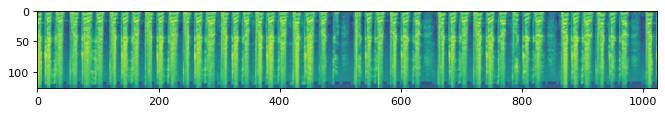

In [58]:
from matplotlib import pyplot as plt
plt.figure(num=1, figsize=(10, 10), dpi=80)
plt.imshow(spc.numpy().transpose(1, 0))
plt.show()
